## SCTransform

A Single-Cell RNA Sequencing Transform Method.

Use regularized negative binomial regression to normalize `UMI` express matrix.

Before we explore the `SCTransform` method, let's see what classic normalization method `Log-Normalization` does.

[2022-11-30 10:11:29][Stereo][30126][140277163226944][reader][546][INFO]: read_gef begin ...
[2022-11-30 10:11:37][Stereo][30126][140277163226944][reader][619][INFO]: the matrix has 9111 cells, and 20816 genes.
[2022-11-30 10:11:37][Stereo][30126][140277163226944][reader][627][INFO]: read_gef end.
[2022-11-30 10:11:43][Stereo][30126][140277163226944][st_pipeline][32][INFO]: start to run normalize_total...
[2022-11-30 10:11:46][Stereo][30126][140277163226944][st_pipeline][35][INFO]: normalize_total end, consume time 2.5460s.
[2022-11-30 10:11:46][Stereo][30126][140277163226944][st_pipeline][32][INFO]: start to run log1p...
[2022-11-30 10:11:48][Stereo][30126][140277163226944][st_pipeline][35][INFO]: log1p end, consume time 1.9208s.


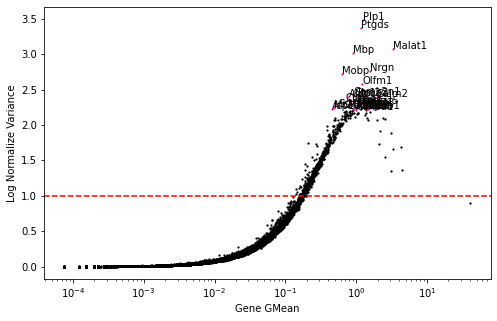

In [1]:
import sys
import stereo as st
import pandas as pd
import numpy as np

data = st.io.read_gef("./SS200000135TL_D1.tissue.gef")
data.sparse2array()

gmean = np.exp(np.log(data.exp_matrix.T + 1).mean(1)) - 1

data.tl.raw_checkpoint()
data.tl.normalize_total(target_sum=1e4)
data.tl.log1p()

log_normalize_result = pd.DataFrame([gmean, data.exp_matrix.T.var(1)], index=['gmean', 'log_normalize_variance'], columns=data.gene_names).T

from stereo.algorithm.sctransform.plotting import plot_log_normalize_var
_ = plot_log_normalize_var(log_normalize_result)

After log-normalization, we can see lowly expressed gene contribute just a little variance in this sample.

[2022-11-30 10:12:11][Stereo][30126][140277163226944][reader][546][INFO]: read_gef begin ...
[2022-11-30 10:12:19][Stereo][30126][140277163226944][reader][619][INFO]: the matrix has 9111 cells, and 20816 genes.
[2022-11-30 10:12:19][Stereo][30126][140277163226944][reader][627][INFO]: read_gef end.
[2022-11-30 10:12:19][Stereo][30126][140277163226944][st_pipeline][32][INFO]: start to run sctransform...
[2022-11-30 10:12:20][Stereo][30126][140277163226944][sctransform][89][INFO]: using default random_seed 1448145, will run SCT without randomness
[2022-11-30 10:12:35][Stereo][30126][140277163226944][vst][114][INFO]: gene-cell umi shape (16458, 9111), n_genes 2000 n_cells 5000
[2022-11-30 10:14:03][Stereo][30126][140277163226944][vst][127][INFO]: get_model_pars finished, cost 83.49463224411011 seconds
[2022-11-30 10:14:08][Stereo][30126][140277163226944][vst][297][INFO]: ksmooth finished, cost 2.111252784729004 seconds
[2022-11-30 10:14:08][Stereo][30126][140277163226944][vst][145][INFO]: 

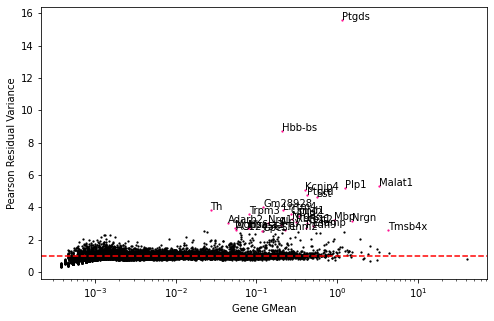

In [2]:
import sys
import stereo as st

data = st.io.read_gef("./SS200000135TL_D1.tissue.gef")
data.tl.sctransform(res_key='sctransform', inplace=True, filter_hvgs=True)

from stereo.algorithm.sctransform.plotting import plot_residual_var
_ = plot_residual_var(data.tl.result['sctransform'])

After `SCTransform`, genes express matrix is transform from raw counts to Pearson residual.

Different with `Log`, normalization method `SCTransform` balances the all genes' variance contribution, which means that not only highly expressed genes will make sense, so do the lowly express genes.

Let take some genes from a real dataset after normalization with `SCTransform`, and see their variance contribution compare to the same dataset normalized with `Log`.

[2022-11-30 16:06:04][Stereo][34936][139889009092416][reader][546][INFO]: read_gef begin ...
[2022-11-30 16:06:12][Stereo][34936][139889009092416][reader][619][INFO]: the matrix has 9111 cells, and 20816 genes.
[2022-11-30 16:06:12][Stereo][34936][139889009092416][reader][627][INFO]: read_gef end.
[2022-11-30 16:06:12][Stereo][34936][139889009092416][st_pipeline][32][INFO]: start to run cal_qc...
[2022-11-30 16:06:12][Stereo][34936][139889009092416][st_pipeline][35][INFO]: cal_qc end, consume time 0.0850s.
[2022-11-30 16:06:15][Stereo][34936][139889009092416][st_pipeline][32][INFO]: start to run sctransform...
[2022-11-30 16:06:15][Stereo][34936][139889009092416][sctransform][89][INFO]: using default random_seed 1448145, will run SCT without randomness
[2022-11-30 16:06:30][Stereo][34936][139889009092416][vst][114][INFO]: gene-cell umi shape (16458, 9111), n_genes 2000 n_cells 5000
[2022-11-30 16:07:35][Stereo][34936][139889009092416][vst][127][INFO]: get_model_pars finished, cost 60.0

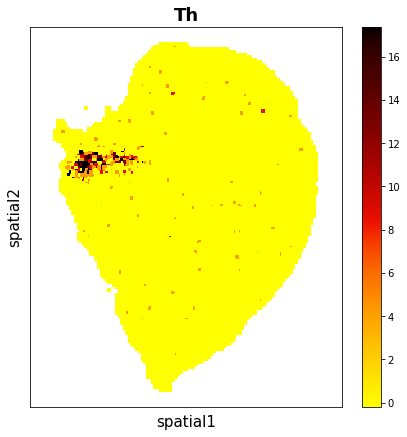

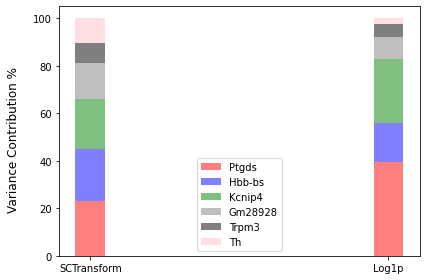

In [54]:
import sys
import stereo as st
import pandas as pd
import numpy as np

data = st.io.read_gef("./SS200000135TL_D1.tissue.gef")
data.tl.cal_qc()
data_sct.plt.spatial_scatter_by_gene(gene_name='Th')
from stereo.algorithm.sctransform.plotting import plot_genes_var_contribution
plot_genes_var_contribution(data, gene_names=['Ptgds','Hbb-bs', 'Kcnip4', 'Gm28928', 'Trpm3', 'Th'])

The gene expression of `Th` is low. In the normalization method of log1p, the contribution of variance will be reduced. But the gene is very specific and concentrated in a certain region. Using the sct standardization method, the variance contribution of the gene can be improved. As a highly variable gene, provide the following analysis method for use.


More contribution from lowly expressed genes, might help us to focus on tiny difference between two cells subtype, which can not be found before because of `Log`'s over shrinking sometimes.

For further exploration, let's try clustering method apply to these result.

Note that sct defaults to sampling with 5000 cells and 2000 genes to use for estimating parameters. If you want to fit with more cells, please adjust the n_cells and n_genes parameters.


In [3]:
import sys

import stereo as st
import time

data_sct = st.io.read_gef('./SS200000135TL_D1.tissue.gef')
data_sct.tl.cal_qc()
data_sct.tl.sctransform(res_key='sctransform', inplace=True, filter_hvgs=True, n_cells=5000, n_genes=2000)
data_sct.tl.pca(use_highly_genes=False, hvg_res_key='highly_variable_genes', n_pcs=20, res_key='pca', svd_solver='arpack')
data_sct.tl.neighbors(pca_res_key='pca', n_pcs=30, res_key='neighbors', n_jobs=8)
data_sct.tl.umap(pca_res_key='pca', neighbors_res_key='neighbors', res_key='umap', init_pos='spectral', spread=2.0)
data_sct.tl.leiden(neighbors_res_key='neighbors', res_key='leiden')

[2022-11-30 14:01:09][Stereo][34936][139889009092416][reader][546][INFO]: read_gef begin ...
[2022-11-30 14:01:16][Stereo][34936][139889009092416][reader][619][INFO]: the matrix has 9111 cells, and 20816 genes.
[2022-11-30 14:01:17][Stereo][34936][139889009092416][reader][627][INFO]: read_gef end.
[2022-11-30 14:01:17][Stereo][34936][139889009092416][st_pipeline][32][INFO]: start to run cal_qc...
[2022-11-30 14:01:17][Stereo][34936][139889009092416][st_pipeline][35][INFO]: cal_qc end, consume time 0.0587s.
[2022-11-30 14:01:17][Stereo][34936][139889009092416][st_pipeline][32][INFO]: start to run sctransform...
[2022-11-30 14:01:17][Stereo][34936][139889009092416][sctransform][89][INFO]: using default random_seed 1448145, will run SCT without randomness
[2022-11-30 14:01:32][Stereo][34936][139889009092416][vst][114][INFO]: gene-cell umi shape (16458, 9111), n_genes 2000 n_cells 5000
[2022-11-30 14:02:36][Stereo][34936][139889009092416][vst][127][INFO]: get_model_pars finished, cost 60.0

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


[2022-11-30 14:04:40][Stereo][34936][139889009092416][st_pipeline][35][INFO]: umap end, consume time 13.8034s.
[2022-11-30 14:04:40][Stereo][34936][139889009092416][st_pipeline][32][INFO]: start to run leiden...
[2022-11-30 14:04:42][Stereo][34936][139889009092416][st_pipeline][35][INFO]: leiden end, consume time 2.2384s.


In [4]:
sct_high_genes = data_sct.tl.result['sctransform'][1]['top_features']

In [5]:
import sys

import stereo as st
import time

data = st.io.read_gef('./SS200000135TL_D1.tissue.gef')
data.tl.filter_genes(gene_list=sct_high_genes.tolist())
data.tl.cal_qc()
data.tl.normalize_total()
data.tl.log1p()
data.tl.scale()
data.tl.pca(use_highly_genes=False, hvg_res_key='highly_variable_genes', n_pcs=20, res_key='pca', svd_solver='arpack')
data.tl.neighbors(pca_res_key='pca', n_pcs=30, res_key='neighbors', n_jobs=8)
data.tl.umap(pca_res_key='pca', neighbors_res_key='neighbors', res_key='umap', init_pos='spectral', spread=2.0)
data.tl.leiden(neighbors_res_key='neighbors', res_key='leiden')

[2022-11-30 14:04:42][Stereo][34936][139889009092416][reader][546][INFO]: read_gef begin ...
[2022-11-30 14:04:48][Stereo][34936][139889009092416][reader][619][INFO]: the matrix has 9111 cells, and 20816 genes.
[2022-11-30 14:04:49][Stereo][34936][139889009092416][reader][627][INFO]: read_gef end.
[2022-11-30 14:04:49][Stereo][34936][139889009092416][st_pipeline][32][INFO]: start to run filter_genes...
[2022-11-30 14:04:49][Stereo][34936][139889009092416][st_pipeline][35][INFO]: filter_genes end, consume time 0.0980s.
[2022-11-30 14:04:49][Stereo][34936][139889009092416][st_pipeline][32][INFO]: start to run cal_qc...
/ldfssz1/ST_BI/USER/stereopy/test/xujunhao/workspace/stereopy_xujunhao_scvelo/stereo/preprocess/qc.py:85: RuntimeWarning: invalid value encountered in true_divide
  pct_counts_mt = mt_count / total_count * 100
[2022-11-30 14:04:49][Stereo][34936][139889009092416][st_pipeline][35][INFO]: cal_qc end, consume time 0.0169s.
[2022-11-30 14:04:49][Stereo][34936][139889009092416]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


[2022-11-30 14:05:06][Stereo][34936][139889009092416][st_pipeline][35][INFO]: umap end, consume time 13.1672s.
[2022-11-30 14:05:06][Stereo][34936][139889009092416][st_pipeline][32][INFO]: start to run leiden...
[2022-11-30 14:05:07][Stereo][34936][139889009092416][st_pipeline][35][INFO]: leiden end, consume time 0.9804s.


<AxesSubplot:title={'center':'leiden'}, xlabel='umap1', ylabel='umap2'>

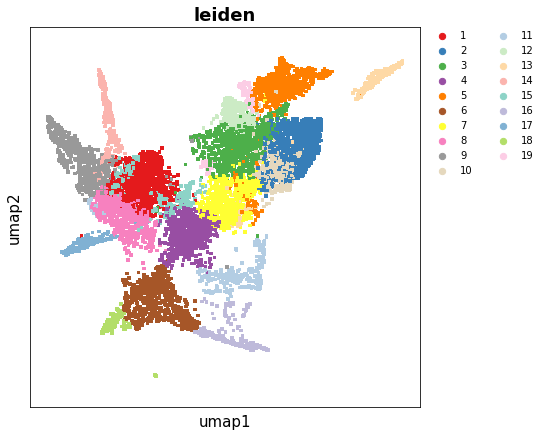

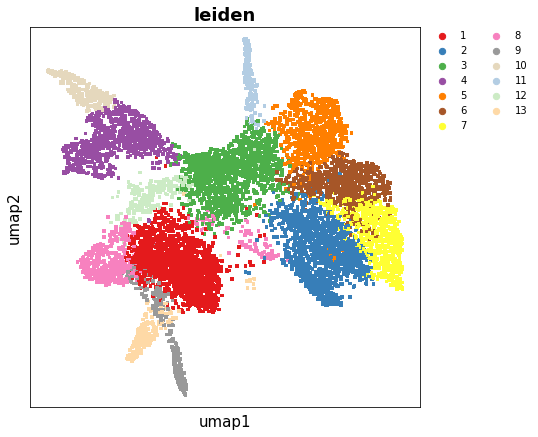

In [19]:
data_sct.plt.umap(res_key='umap', cluster_key='leiden')
data.plt.umap(res_key='umap', cluster_key='leiden')

In [7]:
sct_high_genes.tolist()[:10]

['Ptgds',
 'Hbb-bs',
 'Malat1',
 'Plp1',
 'Kcnip4',
 'Ptprd',
 'Sst',
 'Gm28928',
 'Th',
 'Lrrtm4']

<AxesSubplot:xlabel='umap1', ylabel='umap2'>

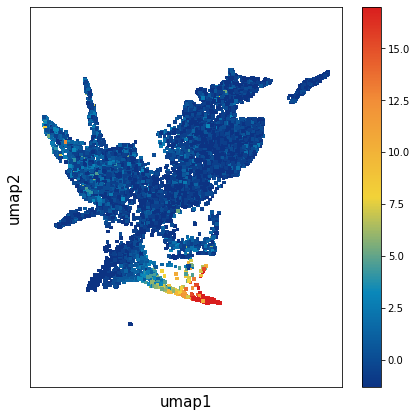

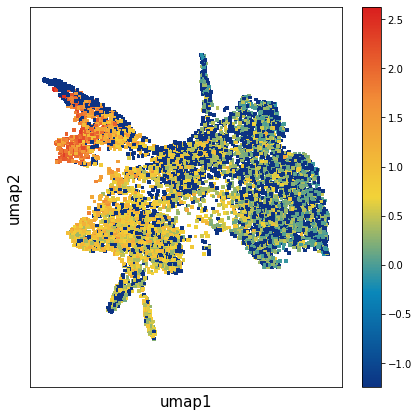

In [53]:
data_sct.plt.umap(res_key='umap', gene_names=['Ptgds'])
data.plt.umap(res_key='umap', gene_names=['Ptgds'])

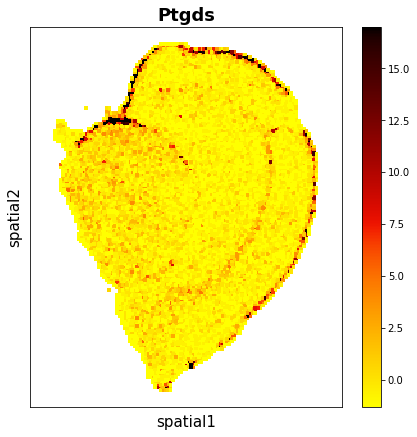

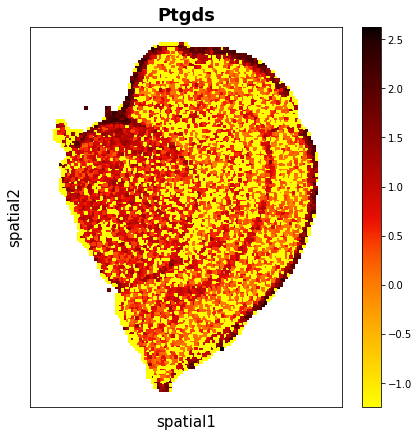

In [52]:
data_sct.plt.spatial_scatter_by_gene(gene_name='Ptgds')
data.plt.spatial_scatter_by_gene(gene_name='Ptgds')